In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report,  f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('server/train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [3]:
train_df = df.iloc[:5_000_000].copy()
test_df = df.iloc[5_000_000:].copy()

До изменения признаков

                       id   Age  Driving_License  Region_Code  \
id                    1.0 -0.00            -0.00        -0.00   
Age                  -0.0  1.00            -0.08         0.04   
Driving_License      -0.0 -0.08             1.00        -0.00   
Region_Code          -0.0  0.04            -0.00         1.00   
Previously_Insured    0.0 -0.28             0.01        -0.02   
Annual_Premium        0.0  0.06            -0.01        -0.00   
Policy_Sales_Channel  0.0 -0.59             0.04        -0.04   
Vintage              -0.0 -0.01            -0.00        -0.01   
Response              0.0  0.12             0.01         0.01   

                      Previously_Insured  Annual_Premium  \
id                                  0.00            0.00   
Age                                -0.28            0.06   
Driving_License                     0.01           -0.01   
Region_Code                        -0.02           -0.00   
Previously_Insured                  1.00         

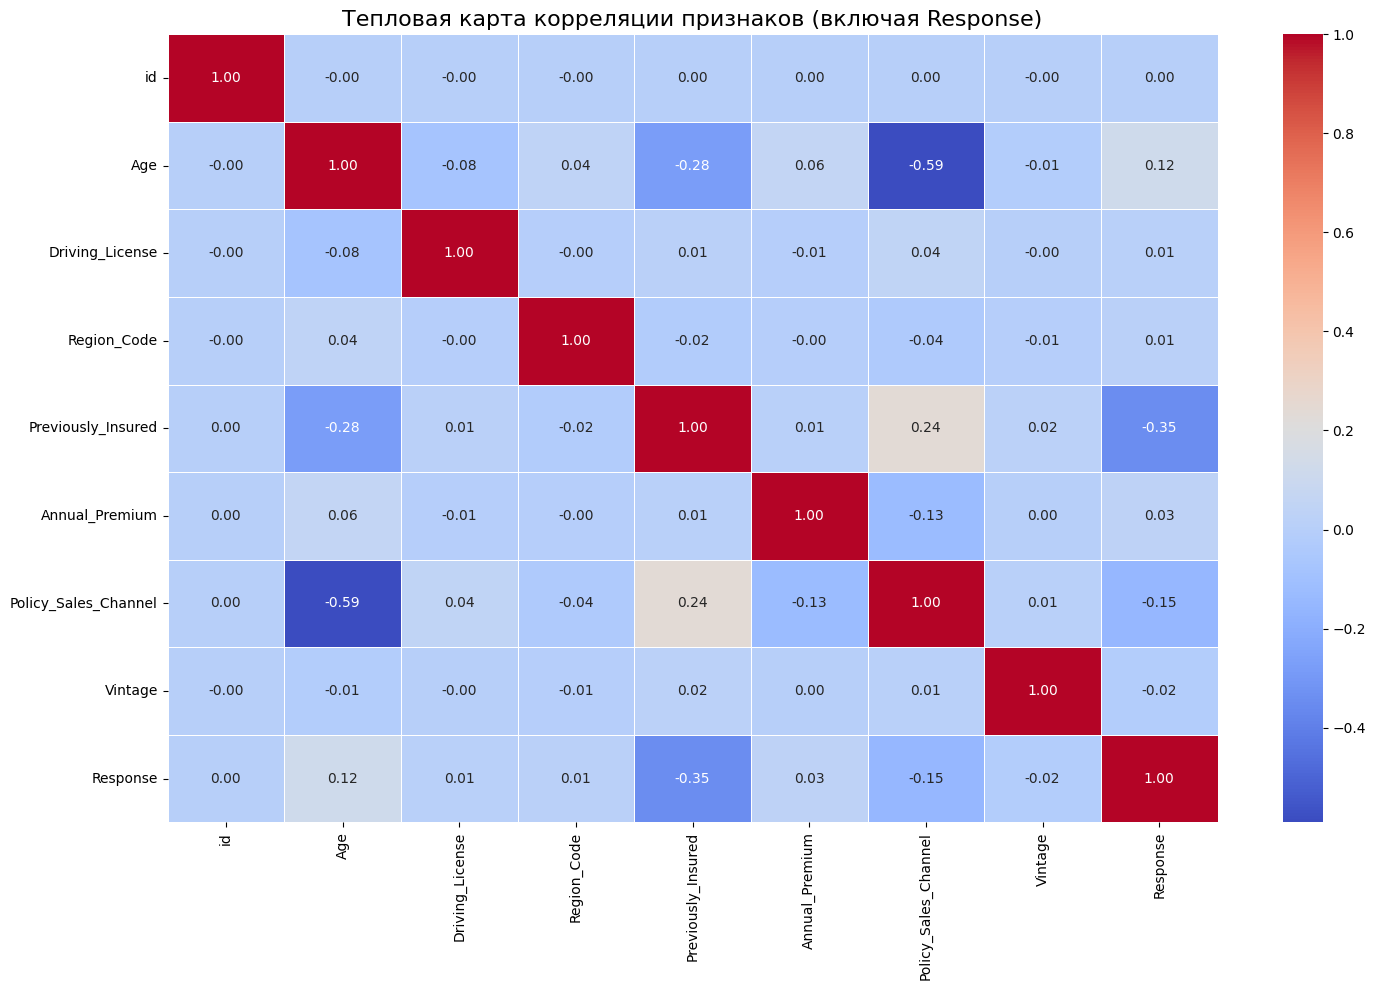

In [4]:
correlation_matrix = train_df.corr(numeric_only=True)
print(correlation_matrix.round(2))
print("-" * 40) 
plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix,
            annot=True,        
            cmap='coolwarm',   
            fmt=".2f",         
            linewidths=.5)
plt.title('Тепловая карта корреляции признаков (включая Response)', fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
#
vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
train_df['Vehicle_Age_Encoded'] = train_df['Vehicle_Age'].map(vehicle_age_mapping)

# Вариант (для Gender)
train_df['Gender'] = np.where(train_df['Gender'] == 'Male', 1, 0) 
# Вариант (для Vehicle_Damage)
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].apply(lambda x: 0 if x == 'No' else 1) 

# добавление признаков
feature_young = 'is_young_driver'
train_df[feature_young] = ((train_df['Age'] >= 20) & (train_df['Age'] < 25)).astype('int8')
feature_old = 'is_old_driver'
train_df[feature_old] = (train_df['Age'] > 61).astype('int8')
feature_region = 'is_special_region'
special_region = train_df['Region_Code'].value_counts().nlargest(2).index
train_df[feature_region] = train_df['Region_Code'].isin(special_region).astype("int8")
train_df['Region_Code'] = train_df['Region_Code'].astype('int8')

# int
train_df['Policy_Sales_Channel'] = train_df['Policy_Sales_Channel'].astype('int16')
#
train_df = train_df.drop(columns='Vehicle_Age')
# удаление id
train_df = train_df.drop(columns='id')
# слабая кореляция
train_df = train_df.drop(columns='Driving_License')

# убираем скошенность
# log
cols_to_process = ['Age']
for col in cols_to_process:
    train_df[col + '_log'] = np.log1p(train_df[col])

cols_to_scale = [col + '_log' for col in cols_to_process]

После добавления признаков

                      Gender   Age  Region_Code  Previously_Insured  \
Gender                  1.00  0.16         0.00               -0.09   
Age                     0.16  1.00         0.04               -0.28   
Region_Code             0.00  0.04         1.00               -0.02   
Previously_Insured     -0.09 -0.28        -0.02                1.00   
Vehicle_Damage          0.10  0.29         0.03               -0.84   
Annual_Premium          0.01  0.06        -0.00                0.01   
Policy_Sales_Channel   -0.12 -0.59        -0.04                0.24   
Vintage                -0.01 -0.01        -0.01                0.02   
Response                0.06  0.12         0.01               -0.35   
Vehicle_Age_Encoded     0.17  0.78         0.04               -0.40   
is_young_driver        -0.12 -0.61        -0.03                0.21   
is_old_driver           0.04  0.64         0.02               -0.06   
is_special_region       0.05  0.29        -0.18               -0.16   
Age_lo

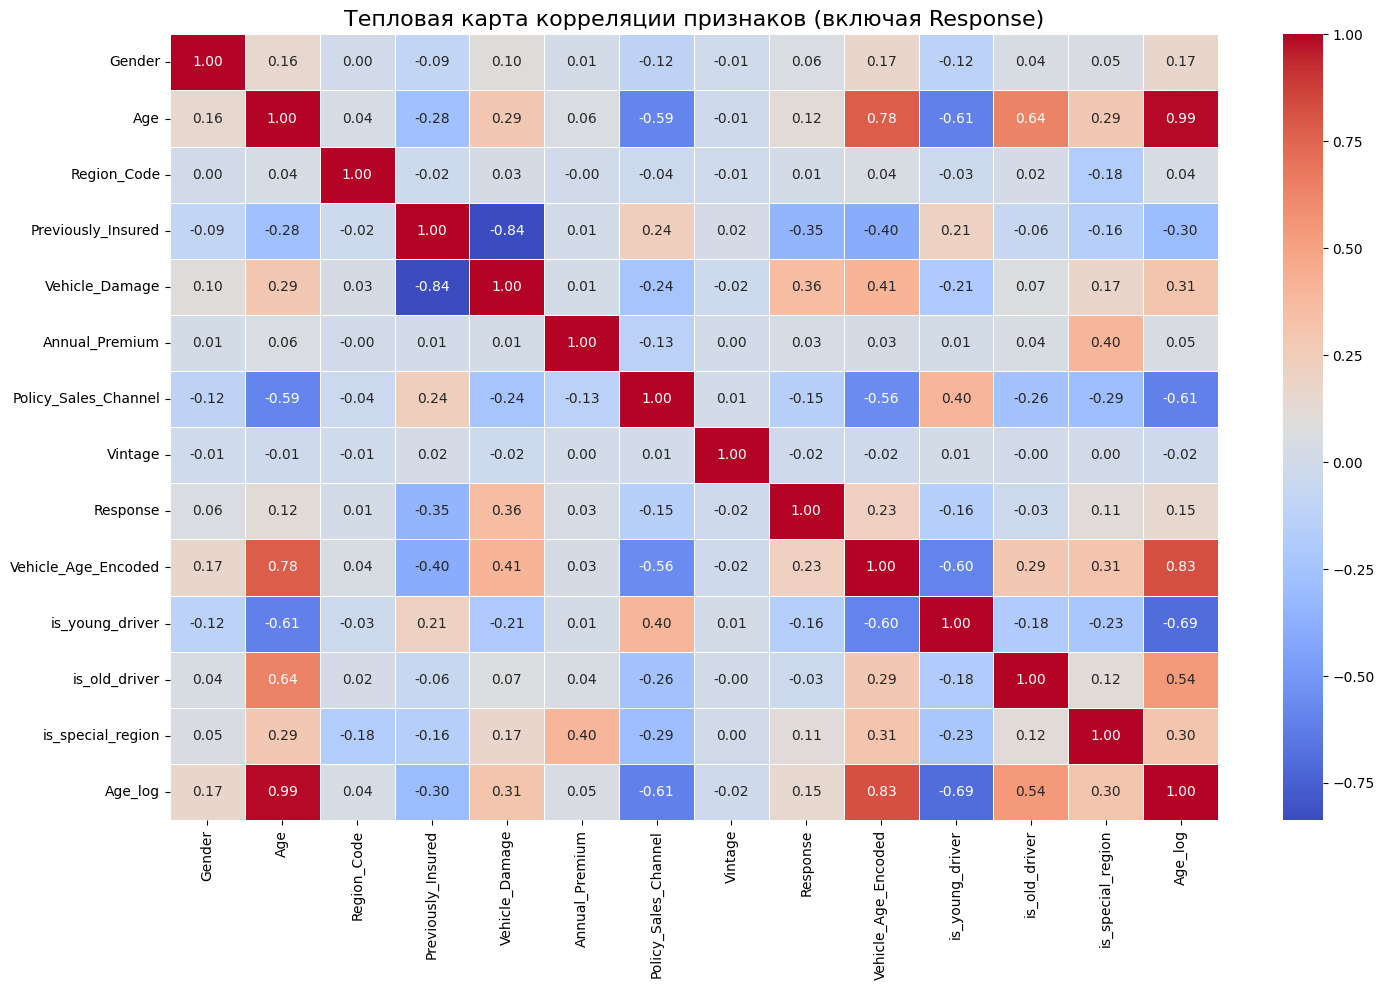

In [6]:
correlation_matrix = train_df.corr(numeric_only=True)
print(correlation_matrix.round(2))
print("-" * 40) 
plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix,
            annot=True,        
            cmap='coolwarm',   
            fmt=".2f",         
            linewidths=.5)
plt.title('Тепловая карта корреляции признаков (включая Response)', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
target_column = 'Response'
X_train = train_df.drop(target_column, axis=1)
y_train = train_df[target_column]

In [8]:
xgb_params = {
    'max_depth': 9,
    'n_estimators': 1000,  
    'reg_lambda': 0.5,     
    'learning_rate': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'random_state': 42
}

In [9]:
count_negative = np.sum(y_train == 0)
count_positive = np.sum(y_train == 1)
estimated_scale_pos_weight = count_negative / count_positive

In [10]:
X_train_fit, X_val_fit, y_train_fit, y_val_fit = train_test_split(
    X_train,
    y_train,
    test_size=0.2, 
    random_state=42,
    stratify=y_train 
)

In [11]:
xgb = XGBClassifier(**xgb_params, scale_pos_weight=estimated_scale_pos_weight)
xgb.fit(
    X_train_fit, 
    y_train_fit,
    eval_set=[(X_val_fit, y_val_fit)],  
    verbose=200                           
)

[0]	validation_0-aucpr:0.36101
[200]	validation_0-aucpr:0.42934
[400]	validation_0-aucpr:0.43437
[600]	validation_0-aucpr:0.43543
[800]	validation_0-aucpr:0.43604
[999]	validation_0-aucpr:0.43624


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [27]:
y_pred_proba = xgb.predict_proba(X_val_fit)[:, 1]

# Находим оптимальный порог по F1
precision, recall, thresholds = precision_recall_curve(y_val_fit, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

# Предсказываем с лучшим порогом
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
new_f1 = f1_score(y_val_fit, y_pred_best)
print(f"Лучший порог: {best_threshold:.3f}, новый F1: {new_f1:.3f}")
weighted_f1 = f1_score(y_val_fit, y_pred_best, average='weighted')
print(f"Взвешенный F1: {weighted_f1:.3f}")
print("лучший порог: ", best_threshold)

Лучший порог: 0.691, новый F1: 0.489
Взвешенный F1: 0.840
лучший порог:  0.6907272


In [20]:
xgb.save_model("server/model.json")

Тест

In [12]:
test_df = df.iloc[5_000_000:].copy()

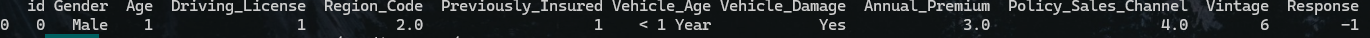

In [13]:
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
5000000,5000000,Female,44,1,36.0,1,1-2 Year,No,2630.0,152.0,182,0
5000001,5000001,Male,61,1,28.0,0,> 2 Years,Yes,41372.0,30.0,77,1
5000002,5000002,Male,44,1,0.0,1,1-2 Year,No,2630.0,122.0,107,0
5000003,5000003,Male,25,1,28.0,0,< 1 Year,No,2630.0,152.0,248,0
5000004,5000004,Female,26,1,2.0,1,< 1 Year,No,38414.0,160.0,24,0


In [14]:
vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
test_df['Vehicle_Age_Encoded'] = test_df['Vehicle_Age'].map(vehicle_age_mapping)

# Вариант (для Gender)
test_df['Gender'] = np.where(test_df['Gender'] == 'Male', 1, 0) 
# Вариант (для Vehicle_Damage)
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].apply(lambda x: 0 if x == 'No' else 1) 

# добавление признаков
feature_young = 'is_young_driver'
test_df[feature_young] = ((test_df['Age'] >= 20) & (test_df['Age'] < 25)).astype('int8')
feature_old = 'is_old_driver'
test_df[feature_old] = (test_df['Age'] > 61).astype('int8')
feature_region = 'is_special_region'
special_region = test_df['Region_Code'].value_counts().nlargest(2).index
test_df[feature_region] = test_df['Region_Code'].isin(special_region).astype("int8")
test_df['Region_Code'] = test_df['Region_Code'].astype('int8')

# int
test_df['Policy_Sales_Channel'] = test_df['Policy_Sales_Channel'].astype('int16')
#
test_df = test_df.drop(columns='Vehicle_Age')
# удаление id
test_df = test_df.drop(columns='id')
# слабая кореляция
test_df = test_df.drop(columns='Driving_License')
# убираем скошенность
# log
cols_to_process = ['Age']
for col in cols_to_process:
    test_df[col + '_log'] = np.log1p(test_df[col])

cols_to_scale = [col + '_log' for col in cols_to_process]

In [15]:
target_column = 'Response'
X_test = test_df.drop(target_column, axis=1)
y_test = test_df[target_column]

In [16]:
# Получаем вероятности для положительного класса
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Находим оптимальный порог по F1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

# Предсказываем с лучшим порогом
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
new_f1 = f1_score(y_test, y_pred_best)
print(f"Лучший порог: {best_threshold:.3f}, новый F1: {new_f1:.3f}")
weighted_f1 = f1_score(y_test, y_pred_best, average='weighted')
print(f"Взвешенный F1: {weighted_f1:.3f}") 

Лучший порог: 0.687, новый F1: 0.489
Взвешенный F1: 0.839


In [17]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89   5705020
           1       0.37      0.72      0.49    799778

    accuracy                           0.82   6504798
   macro avg       0.66      0.77      0.69   6504798
weighted avg       0.88      0.82      0.84   6504798



In [18]:
train_df.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_Encoded,is_young_driver,is_old_driver,is_special_region,Age_log
0,1,21,35,0,1,65101.0,124,187,0,1,1,0,0,3.091042
1,1,43,28,0,1,58911.0,26,288,1,2,0,0,1,3.784190
2,0,25,14,1,0,38043.0,152,254,0,0,0,0,0,3.258097
3,0,35,1,0,1,2630.0,156,76,0,1,0,0,0,3.583519
4,0,36,15,1,0,31951.0,152,294,0,1,0,0,0,3.610918


In [19]:
test_df.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_Encoded,is_young_driver,is_old_driver,is_special_region,Age_log
5000000,0,44,36,1,0,2630.0,152,182,0,1,0,0,0,3.806662
5000001,1,61,28,0,1,41372.0,30,77,1,2,0,0,1,4.127134
5000002,1,44,0,1,0,2630.0,122,107,0,1,0,0,0,3.806662
5000003,1,25,28,0,0,2630.0,152,248,0,0,0,0,1,3.258097
5000004,0,26,2,1,0,38414.0,160,24,0,0,0,0,0,3.295837


In [21]:
test_loading = XGBClassifier()
test_loading.load_model("server/model.json")

In [28]:
y_pred_proba = test_loading.predict_proba(X_test)[:, 1]

best_threshold = 0.69

# Предсказываем с лучшим порогом
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
new_f1 = f1_score(y_test, y_pred_best)
print(f"Лучший порог: {best_threshold:.3f}, новый F1: {new_f1:.3f}")
weighted_f1 = f1_score(y_test, y_pred_best, average='weighted')
print(f"Взвешенный F1: {weighted_f1:.3f}") 

Лучший порог: 0.690, новый F1: 0.489
Взвешенный F1: 0.840
